
# <center> ALONI DI MATERIA OSCURA
**<center>Esame di Tecniche di Rappresentazione e Modellizzazione Dati**\
\
**<center>Pian Sebastiano**
**<center>Marzo 2024**




**Introduzione**\
\
Gli aloni di materia oscura sono strutture gravitazionalmente legate che svolgono un ruolo
chiave nella formazione delle strutture cosmiche, agendo da nuclei gravitazionali intorno
ai quali si aggrega la materia ordinaria, come gas e stelle, formando galassie e ammassi
di galassie.\
La caratterizzazione del profilo di densità degli aloni ha molteplici applicazioni
in studi cosmologici come la stima della massa di un ammasso di galassie da misure di
lensing gravitazionale, o lo studio delle proprietà della materia oscura.\
\
Il profilo di densità proiettato degli aloni di materia oscura è descritto dalla funzione (2D projected NFW profile)\
\
$\Sigma(𝑅, 𝑀, 𝑐, 𝑧) = 2 f(𝑥) \rho_s r_s$.\
 \
M è la massa dell'alone di materia oscura, c la concentrazione, z il suo redshift e R distanza dal centro.\
\
$r_s$ è il raggio caratteristico dell'ammasso, pari a $(3M/(4\pi 200 \rho_m (1+z)^{3})^{1/3})/c$,\
dove $\rho_m \simeq 0.286\cdot0.7^2\cdot2.7751428946e11[M_s/ Mpc]$ è la densità media dell'universo e 
$\rho_s$ è la densità caratteristica dell'ammasso, pari a\
\
 $\rho_m (1+z)^3 \delta_{char}$ con $\delta_{char}= \frac{200 c^3}{3 f_c}$ e\
 \
$f_c= ln(1+c) - c/(1+c)$. \
\
Infine\
\
$ f(x) = \begin{cases}
    (\frac{1}{x^2 - 1})[1 - \frac{2}{\sqrt(1-x^2)}\operatorname{arctanh}(\sqrt(\frac{1-x}{1+x}))]  & \text{se } x < 1 \\
    \frac{1}{3} & \text{se } x = 1 \\
   (\frac{1}{x^2 - 1})[1 - \frac{2}{\sqrt(x^2 -1)}\operatorname{arctanh}(\sqrt(\frac{x-1}{1+x}))]  & \text{se } x > 1 \\ 
\end{cases}$ \
\
con $x = \frac{R}{r_s}$.\
\
**Consegna**\
\
La consegna è divisa in due parti.\
\
Nella parte 1 è richiesto di implementare la funzione $\Sigma(R,M,c,z)$ e mostrare in un grafico i profili di densità nell'intervallo $R = (0.3,1)Mpc$ per $M = [1e13.5, 1e14, 1e15] M_s$ , $c = [2,5,10]$ e z=0.\
\
Nella parte 2, dopo aver letto il file 'halo_catalog.fit', si chiede di suddividere il catalogo nei 5 intervalli di ricchezza $\lambda = [15,20,30,45,60,200]$, calcolare il redshift, profilo di densita' medio e sua deviazione standard in funzione di R per ognuno di questi e mostrare i risultati in un grafico con 5 pannelli. Successivamente, usando il fit analtico NFW, stimare per ogni bin di ricchezza la massa e la concentrazione media, assumendo una *likelihood* Gaussiana, utilizzando le matrici di covarianza fornite nel file 'covariance_matrice.npy' e considerando *prior* uniformi per i parametri: $log_{10}(M) = (13,16)$ e $ c = (0.2,20)$.\
Si chiede poi di riportare il valore di best-fit, il valor medio ed errore associato ad ogni parmetro, fare un grafico triangolare per ogni intervallo di ricchezza per mostrare i posteriors ottenuti sui due parametri e verificare la bonta' del fit calcolando il $\chi^2$ per i best fit parameters. Confrontare infine i dati con 100 valori estratti dalle catene
e commentare i risultati.\
\
Il file 'halo_catalog.fit', contenente i profili di densità di 40103 aloni di materia oscura estratti da una simulazione cosmologica N-body, il loro redshift e la loro ricchezza (che funge da *proxy* per la massa). I nomi delle colonne contenenti i dati sono rispettivamente: redshift='Z', ricchezza='LAMBDA_TR', profilo densità='SIGMA_of_R' [M Mpc ]. I valori di R in [Mpc] a cui sono calcolati i profili di densità si trovano nel file 'R_values.npy'.

**Parte 1**\
\
Come prima cosa chiamo i pacchetti necessari.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pygtc
from astropy.io import fits
import emcee

Definisco le funzioni chedescrivono il profilo di densità $\Sigma(R,M,c,z)$.

In [43]:

def Sigma(R, M, c, z):
   
    rho_m = 0.286 * (0.7**2) * (2.7751428946 * 10**11) 
    f_c = np.log(1 + c) - (c/(1 + c))
    delta_c = (200 * c**3) / (3 * f_c)
    rho_s = rho_m  * ((1 + z)**3) * delta_c
    r_s = (((3 * M) / ((4 * np.pi * 200* rho_m* ((1 + z)**3))))**(1 / 3))/c
    x = R/r_s
    f_x = np.zeros_like(x)
  
    for i in range (len(x)):
      if(x[i]<1):
        f_x[i]=(1-(2*np.arctanh(np.sqrt((1-x[i])/(1+x[i]))))/(np.sqrt(1-x[i]**2)))/(x[i]**2-1)
      elif(x[i]==1):
        f_x[i]=1/3
      else:
        f_x[i]=(1-(2*np.arctan(np.sqrt((x[i]-1)/(1+x[i]))))/(np.sqrt(x[i]**2-1)))/(x[i]**2-1)
        
    return 2 * f_x * r_s * rho_s

Ora costruisco un grafico composto da 9 pannelli che mostrano (in scala logaritmica) i rispettivi profili di densità negli intervalli richiesti, con z=0.

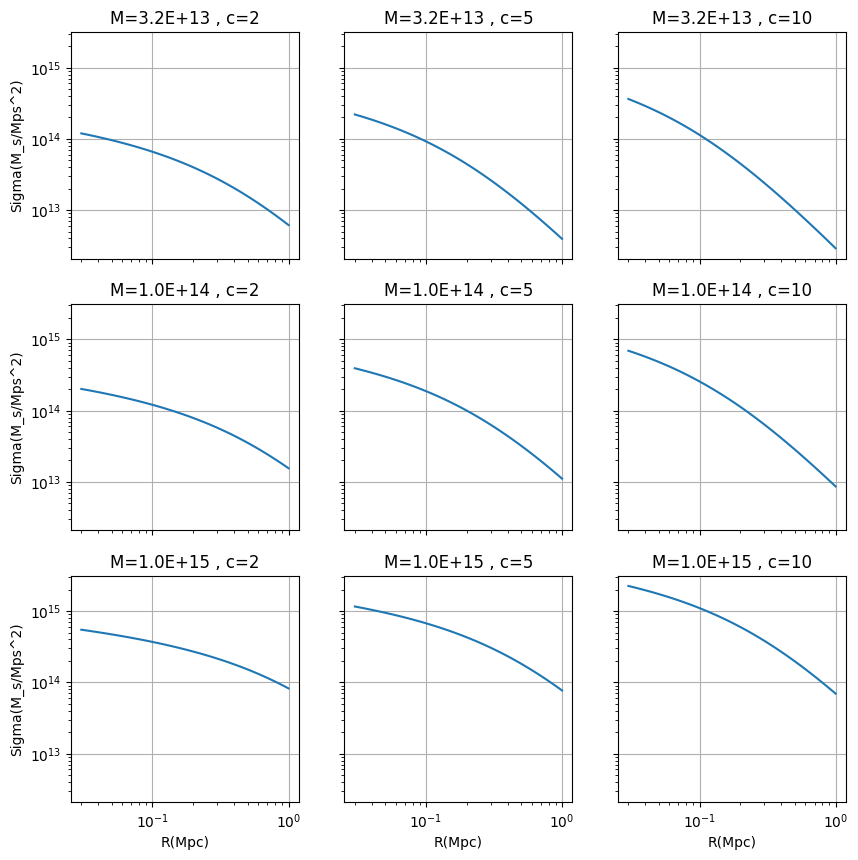

In [44]:
mass = [10**13.5, 10**14.0, 10**15.0]
conc = [2, 5, 10]
z = 0.0 
R_values = np.logspace(np.log10(0.03), np.log10(1.0), base = 10)

fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

for i in range(3):
    
    for j in range(3) :

        S = Sigma(R_values, mass[i], conc[j], z)
        axes[i, j].loglog(R_values, S, base=10)
        axes[i, 0].set_ylabel('Sigma(M_s/Mps^2)')
        axes[2, j].set_xlabel('R(Mpc)')
        txt= f'M={mass[i]:.1E} , c={conc[j]}'
        axes[i,j].set_title(label= f'{txt}')
        axes[i,j].grid(True)

L'andamento decrescente dei profili è giustificabile dal fatto che la densità media diminuisce allontanandosi dal centro dell'alone.\
Si può notare che all'aumentare della massa, fissando la concentrazione, il profilo si trasla verso l'alto (ragionevolmente) e accade lo stesso fissando la massa e aumentando la concentrazione.

**Parte 2**

Come prima cosa leggo i file necessari nominando le rispettive colonne.

In [45]:
data = fits.getdata('halo_catalog.fit')
R_val = np.load('R_values.npy')
ric = data['LAMBDA_TR']
den = data['SIGMA_of_R']
cov = np.load('covariance_matrices.npy')

Divido ora i dati nei 5 intervalli richiesti. Calcolo poi il redshift medio, media e deviazione standard di ogni valore del profilo di densità nell'intervallo e vado a riportare le 5 curve ottenute.

Redshift medio per il gruppo 1= 0.46009

Redshift medio per il gruppo 2= 0.46389

Redshift medio per il gruppo 3= 0.45921

Redshift medio per il gruppo 4= 0.45644

Redshift medio per il gruppo 5= 0.44109



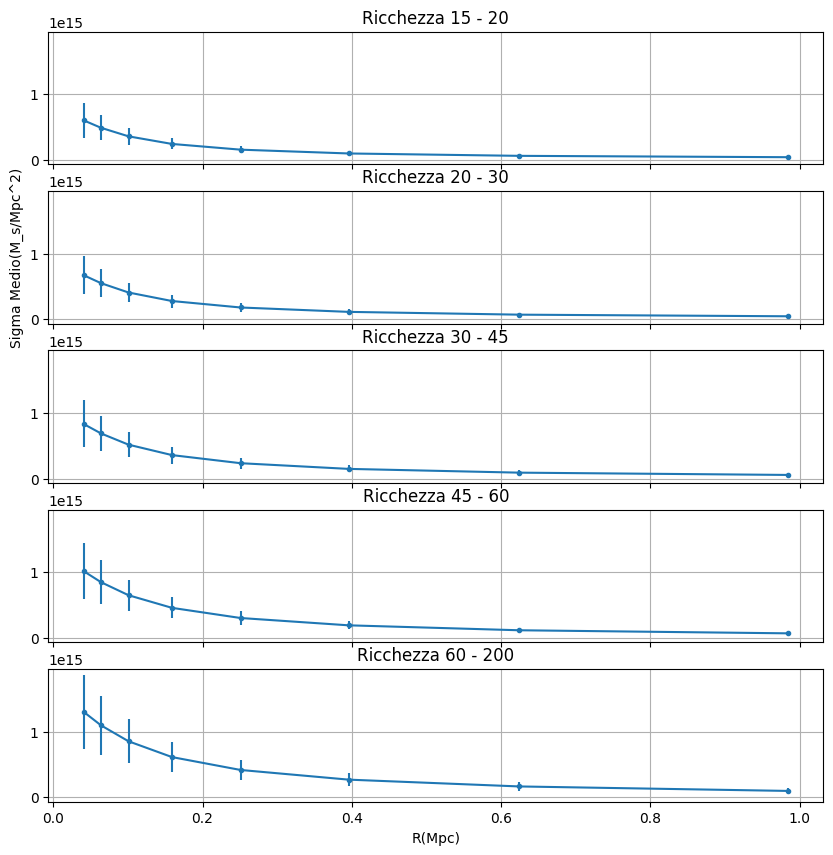

In [46]:
redshift= np.zeros(5)
density = np.ndarray((5,8))
lambd = np.array([15, 20, 30, 45, 60, 200])

fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True, sharey=True)

for i in range(5):
    
    if i < 4:
        data_i = data[(ric >= lambd[i]) & (ric < lambd[i + 1])]
    else:
        data_i = data[(ric >= lambd[i])]

    redshift_m = np.mean(data_i['Z'])
    redshift[i] = redshift_m
    den_m = np.mean(data_i['SIGMA_of_R'], axis=0)
    density[i] = den_m
    den_std= np.std(data_i['SIGMA_of_R'], axis=0)
    print(f'Redshift medio per il gruppo {i+1}=', round(redshift_m, 5))
    print()
    axs[i].set_title(f'Ricchezza { lambd[i]} - {lambd[i+1]}')
    axs[i].errorbar(R_val, den_m, yerr=den_std, fmt='.-')
    axs[4].set_xlabel('R(Mpc)')
    axs[1].set_ylabel('Sigma Medio(M_s/Mpc^2)')
    axs[i].grid(True)   

Notiamo che le curve di densità si  alzano al crescere della ricchezza, che sembra essere logico in quanto questa è un *proxy* della massa. Le deviazioni standard diminuscono con l'aumentare della distanza, poichè evidentemente in ogni simulazione per R grandi c'è maggiore coerenza tra i valori ottenuti.\
\
Definisco ora le funzioni di *prior* sui parametri, il logaritmo della *likelihood* e la *posterior*.

In [47]:
def log_likelihood(theta, r, data, cov, z):
    logM, c = theta
    m = 10**(logM)
    cov_inv = np.linalg.inv(cov)
    
    return -0.5 * np.dot( data - Sigma(r, m, c, z), np.dot(cov_inv, data - Sigma(r, m, c, z)))

def log_prior(theta):
    logM, c = theta
    
    if 13 <= logM <= 16 and 0.2 <= c <= 20:
        return 0.0
    return -np.inf
    
def log_posterior(theta, r, data, cov, z):
    
    if not np.isfinite(log_prior(theta)):
        return -np.inf
    return log_prior(theta) + log_likelihood(theta, r, data, cov, z)

Ora, utilizzando la funzione *minimize* (di *scipy*) sul *log-likelihood* faccio in ogni intervallo una prima stima dei parametri M (per semplicità di calcolo uso $log_{10}(M)$) e c. A partire da questi valori, che saranno la posizione iniziale dei *walkers*, inizializzo la catena di Markov(MCMC), utilizzando il software *EMCEE*, in questo caso facendo 2000 passi.

100%|██████████| 2000/2000 [00:13<00:00, 148.39it/s]


autocorrect time: [29.47914165 26.95339443]
(60800, 2)


100%|██████████| 2000/2000 [00:11<00:00, 169.68it/s]


autocorrect time: [28.46674413 27.35211281]
(60800, 2)


100%|██████████| 2000/2000 [00:13<00:00, 152.65it/s]


autocorrect time: [26.66393025 28.29806335]
(60800, 2)


100%|██████████| 2000/2000 [00:12<00:00, 157.26it/s]


autocorrect time: [25.98113791 29.48202859]
(60800, 2)


100%|██████████| 2000/2000 [00:13<00:00, 147.56it/s]


autocorrect time: [30.77771746 29.91408676]
(60800, 2)


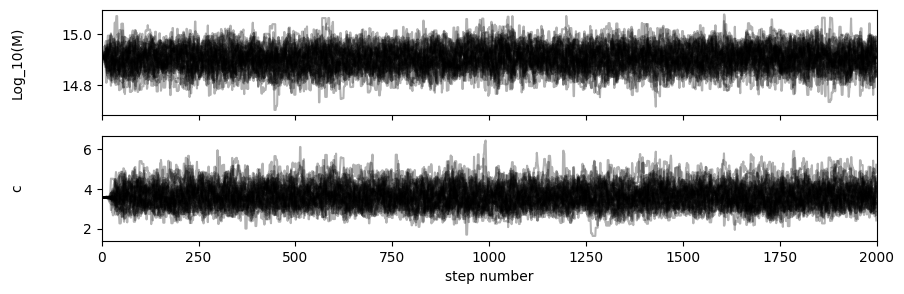

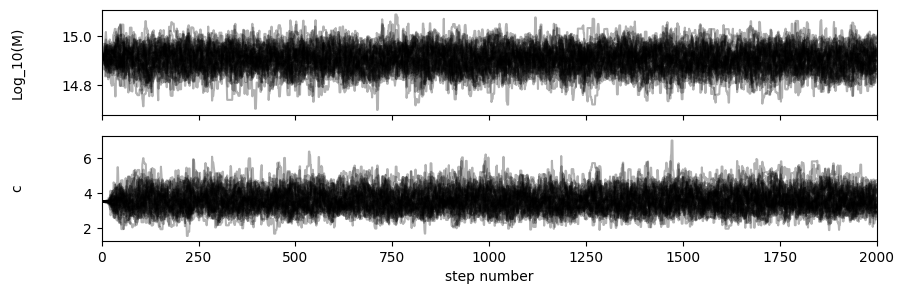

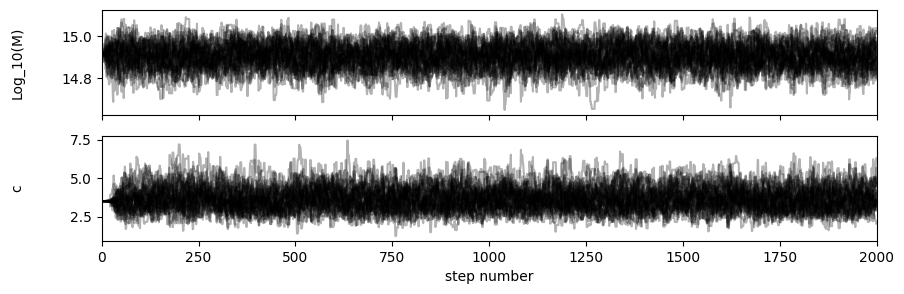

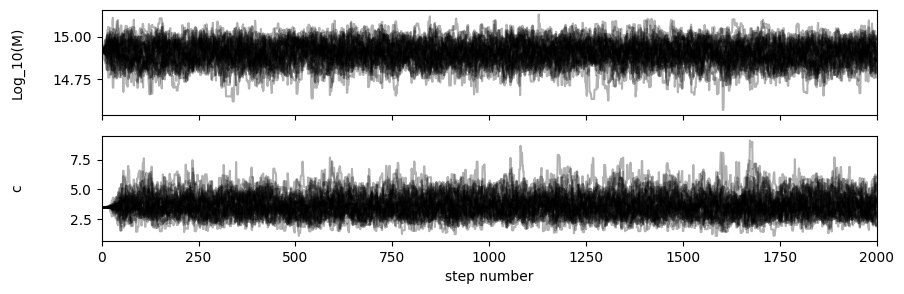

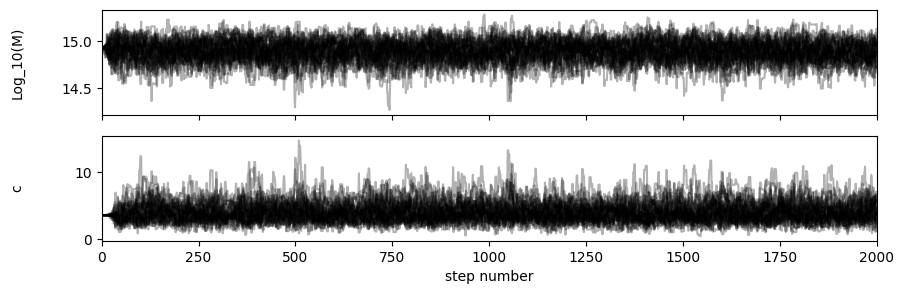

In [49]:
results = np.ndarray((5,60800,2)) 
logM_f= np.zeros(5)
c_f=np.zeros(5) 

for i in range(5):
    
    nll = lambda *args: -log_posterior(*args)
    initial = np.array([14.9, 3.5]) * (1 + 0.01* np.random.randn(2))
    soln = minimize(nll, initial, args=(R_val, den_m, cov[i], redshift[i]))
    logM_f[i], c_f[i] = soln.x

    pos = soln.x * (1 + 0.0001 * np.random.randn(32,2))
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                    log_posterior, args=(R_val, den_m, cov[i], redshift[i]))
    sampler.run_mcmc(pos, 2000, progress=True)

    fig, axes = plt.subplots(2, figsize=(10, 3), sharex=True)
    samples = sampler.get_chain()
    labels = ["Log_10(M)", "c"]

    for j in range(ndim): 
        ax = axes[j]
        ax.plot(samples[:, :, j], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[j])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        
    axes[-1].set_xlabel("step number")
    
    tau = sampler.get_autocorr_time()
    print("autocorrect time:", tau)
    flat_samples = sampler.get_chain(discard=100, flat=True)
    print(flat_samples.shape)
    results[i]= flat_samples

Questi grafici mostrano ad ogni step della catena di Markov le posizioni assunte dai walkers nello spazio dei parametri. Le catene oscillano tutte attorno ad un valore, che sarà, per la legge dei grandi numeri, il valore di aspettazione del parametro, in corrispondenza del quale troveremo il picco della *posterior* distribution.\
\
Ora calcolo e scrivo valori medi e deviazioni standard dei parametri stimati nei vari intervalli, oltre al best-fit restituito dalla funzione *minimize*.

In [50]:
logM_m = np.zeros(5)  
c_m = np.zeros(5)
logM_std = np.zeros(5)
c_std = np.zeros(5)

for i in range(5):
    logM_m[i] = np.mean(results[i,:,0])
    c_m[i] = np.mean(results[i,:,1])
    logM_std[i] = np.std(results[i,:,0])
    c_std[i] = np.std(results[i,:,1])
    print()
    print("Intervallo di ricchezza:", lambd[i], "-", lambd[i+1])
    print()
    print('Best fit log_10(M):', round(logM_f[i],5))
    print("Valor medio log_10(M):", round(logM_m[i],5))
    print("Deviazione standard log_10(M):", round(logM_std[i],5))
    print('Best fit c:',round(c_f[i],5))
    print('Valor medio c:', round(c_m[i],5))
    print('Deviazione standar c:', round(c_std[i],5))


Intervallo di ricchezza: 15 - 20

Best fit log_10(M): 14.91079
Valor medio log_10(M): 14.90558
Deviazione standard log_10(M): 0.04507
Best fit c: 3.55947
Valor medio c: 3.63693
Deviazione standar c: 0.54468

Intervallo di ricchezza: 20 - 30

Best fit log_10(M): 14.91205
Valor medio log_10(M): 14.90489
Deviazione standard log_10(M): 0.04882
Best fit c: 3.51832
Valor medio c: 3.61457
Deviazione standar c: 0.59896

Intervallo di ricchezza: 30 - 45

Best fit log_10(M): 14.91662
Valor medio log_10(M): 14.90488
Deviazione standard log_10(M): 0.0573
Best fit c: 3.5062
Valor medio c: 3.65672
Deviazione standar c: 0.74783

Intervallo di ricchezza: 45 - 60

Best fit log_10(M): 14.91857
Valor medio log_10(M): 14.90357
Deviazione standard log_10(M): 0.06541
Best fit c: 3.49777
Valor medio c: 3.64929
Deviazione standar c: 0.89631

Intervallo di ricchezza: 60 - 200

Best fit log_10(M): 14.92471
Valor medio log_10(M): 14.89307
Deviazione standard log_10(M): 0.11087
Best fit c: 3.56817
Valor medio c:

Vado a vedere i grafici triangolari grazie al pacchetto *pygtc*.

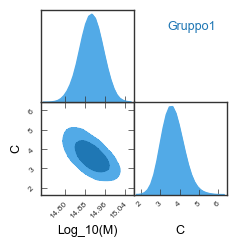

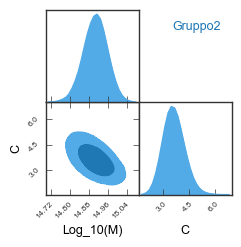

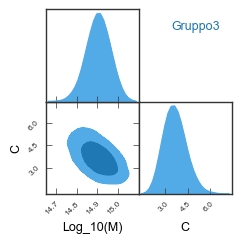

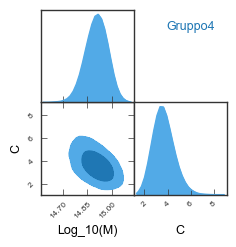

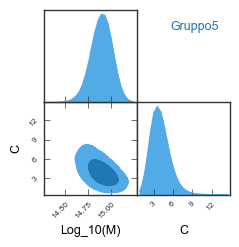

In [51]:
for i in range(5):
        GTC = pygtc.plotGTC(chains=results[i],
                    paramNames=['Log_10(M)','C'],
                    chainLabels=[f'Gruppo{i+1}'],
                    figureSize='MNRAS_column')

I grafici triangolari ci permettono di visualizzare le correlazioni tra i parametri e le loro *posterior* distribution. Essendo la *posterior* la somma della funzione di *likelihood* e della funzione di *prior*, ci si aspettano naturalmente delle posterior gaussiane; inoltre è evidente la presenza di una correlazone tra la massa e la densità di un ammasso di materia oscura.

Ora, per avere una misura della bontà della stima, calcolo il $\chi^2$ ridotto per i parametri stimati dalla MCMC rispetto al valore di best-fit.\
Ricordo che \
\
$\chi^2 = \sum_{i=1}^{n} \frac{(x_i - \mu)^2}{\sigma_i^2}$

In [52]:
for i in range (5):
    
    chi_squared_m = np.sum((results[i,:,0] - logM_f[i])**2 / logM_std[i]**2)/ np.shape(results[i,:,0])
    chi_squared_c = np.sum((results[i,:,1] - c_f[i])**2 / c_std[i]**2) / np.shape(results[i,:,1])
    print('Chi-quadro ridotto per il gruppo', i+1, ':')
    print()
    print('log_10(M)',chi_squared_m,'c', chi_squared_c)
    print()

Chi-quadro ridotto per il gruppo 1 :

log_10(M) [1.01336883] c [1.02022494]

Chi-quadro ridotto per il gruppo 2 :

log_10(M) [1.02146715] c [1.02582453]

Chi-quadro ridotto per il gruppo 3 :

log_10(M) [1.04201957] c [1.04051402]

Chi-quadro ridotto per il gruppo 4 :

log_10(M) [1.05256672] c [1.02858022]

Chi-quadro ridotto per il gruppo 5 :

log_10(M) [1.08145158] c [1.08939853]



$\chi^2$ ridotto è uguale a $\frac{\chi^2}{n}$. Poichè il valore di aspettazione di $\chi^2$ è n, ci si aspetta che quello del ridotto sia 1. La vicinanza dei valori ottenuti con le previsioni teoriche ci fa pensare che l'ipotesi sulla distribuzuine dei parametri e sui loro valori siano estremamente verosimili.

Estraggo infine 100 valori casuali dei parametri stimati in ogni intervallo di ricchezza dalla MCMC e rappresento i rispettivi profili.

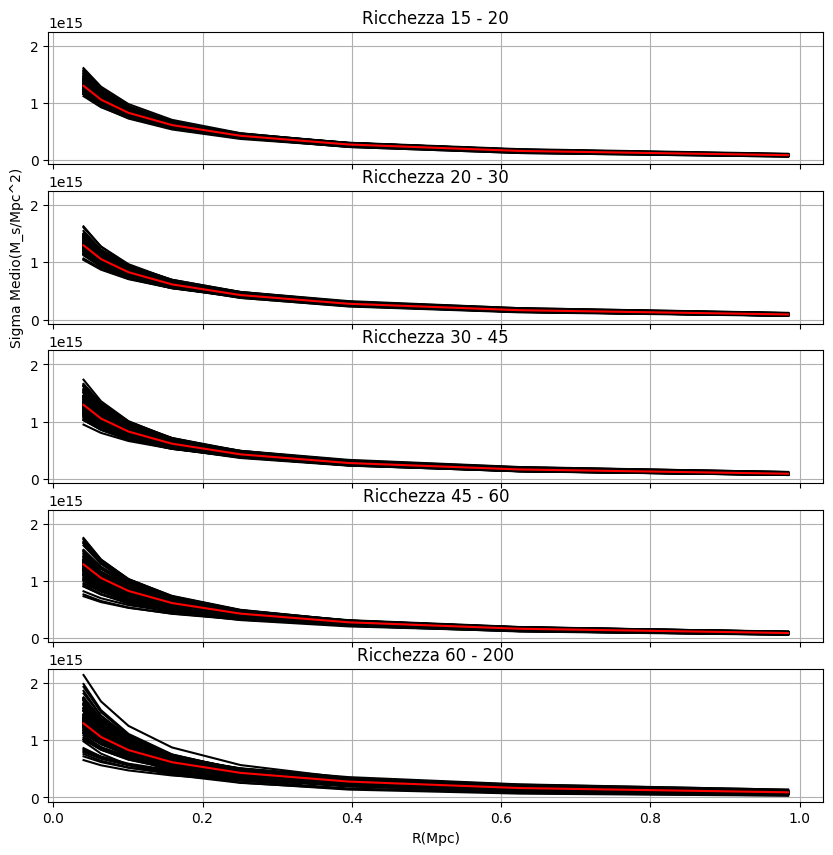

In [53]:
for i in range(len(results)):
    
    rand = np.random.choice(results[i].shape[0] , 100, replace=False)
    
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True, sharey=True)

for i in range(5):
               
    for j in range(100):
    
        p_rand= Sigma(R_val, 10**results[i, rand[j], 0], results[i, rand[j], 1] , redshift[i])
        axs[i].plot(R_val, p_rand, color='black')
        
    axs[i].set_title(f'Ricchezza { lambd[i]} - {lambd[i+1]}')
    axs[i].plot(R_val, Sigma(R_val, 10**logM_f[i], c_f[i], redshift[i]), color='red', label='Best Fit')
    axs[4].set_xlabel('R(Mpc)')
    axs[1].set_ylabel('Sigma Medio(M_s/Mpc^2)')
    axs[i].grid(True)    

Le linee rosse rappresentano i profili di densità stimati dai parametri di best-fit, mentre le linee nere rappresentano il profilo di densità atteso calcolato con i 100 valori estratti casualmente. Notiamo che all'aumentare di R i 100 valori sembrano convergere meglio verso la curva che descrive il profilo di densità osservato.